In [24]:
from __future__ import division

from pylab import *
import scipy
import time

import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [25]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

# Unbinding via Inference

Generally, we are faced with a fundamental inference problem in hypercomputing. I think that the simplest expression of this problem is to decompose an input that was generated by binding two vectors together. These vectors both come from a known dictionary, but it is not so straight-forward to infer which vectors were bound together to generate the input.

First, lets walk through a standard HD algorithm for solving the inverse binding problem. We are going to set up two sets of symbols -- one set that, say, represents objects (`obj_vecs`), and another that represents transformations (`trf_vecs`). What we expect is that symbols chosen from each set are bound together by multiplication, and the goal is to find the original two vectors.


In [26]:
N = 1000

objD = 27
trfD = 20

obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1

obj_vecs = obj_vecs / N**0.5
trf_vecs = trf_vecs / N**0.5

In [27]:
obj_idx = 5
trf_idx = 2

bound_vec = obj_vecs[obj_idx, :] * trf_vecs[trf_idx, :]
#bound_vec = (obj_vecs[2, :] + 0.5*obj_vecs[16,:]) * (trf_vecs[3, :] + 0.5*trf_vecs[7,:])

So the basic strategy to find the vectors bound together would be to implement this:

$$
\hat{X} = \left( \sum_\mu T_{\mu} \right) \times \mathbf{B}
$$

$$
\max_\ell \hat{X} \cdot X
$$

where $\mathbf{B}$ is the bound vector pair. e.g.:

$$ 
\mathbf{B} = X_\ell \times T_m
$$

Of course, everything is perfectly symmetrical for $T$:

$$
\hat{T} = \left( \sum_\ell X_\ell \right) \times \mathbf{B}
$$

$$
\max_\mu \hat{T} \cdot T
$$


This will also be noisy, as we are superposing all `trfD` transforms onto a single dereferencing vector.

In [28]:
x_coef = np.dot(obj_vecs, trf_vecs.sum(axis=0) * bound_vec)
t_coef = np.dot(trf_vecs, obj_vecs.sum(axis=0) * bound_vec)

We can now decode the result and figure out the original vectors that were bound together.

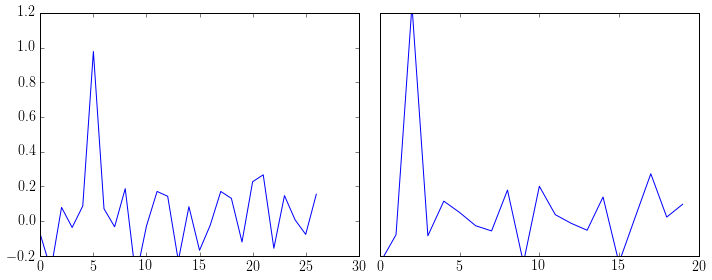

In [29]:
figure(figsize=(10,4))

subplot(121)
plot(x_coef * N)
ylim([-0.2, 1.2])

subplot(122)
plot(t_coef * N)
ylim([-0.2, 1.2])
yticks([])

plt.tight_layout()

**Figure: Basic HD algorithm for unbinding inference.** The two peaks correspond to the two vectors bound together.

So that basically works! But, we can actually do better by repeating the whole process. To get these histograms, we had to start with a guess -- which we initialized as the sum of all the possibilities. However, this adds noise due to the superposition. We can reduce the noise by trying again, this time using the results from the first step as the guess.


In [30]:
xc_sum = np.dot(N*x_coef.T, obj_vecs) # our new guess is based on the coefficients from the frist step
tc_sum = np.dot(N*t_coef.T, trf_vecs)
x_coef2 = np.dot(obj_vecs, tc_sum * bound_vec)
t_coef2 = np.dot(trf_vecs, xc_sum * bound_vec)

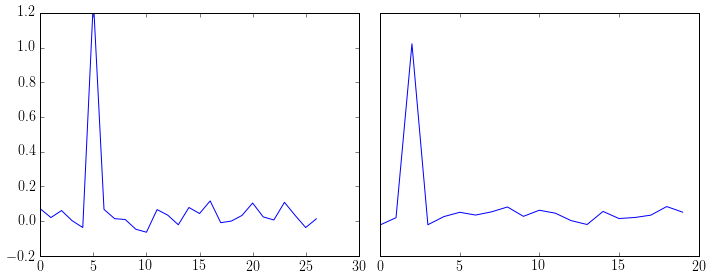

In [31]:
figure(figsize=(10,4))

subplot(121)
plot(x_coef2 * N)
ylim([-0.2, 1.2])

subplot(122)
plot(t_coef2 * N)
ylim([-0.2, 1.2])
yticks([])

plt.tight_layout()

**Figure: Second iteration of unbinding inference.** The noise is greatly reduced.

Lets continue to iterate and see if there is anymore improvement.

In [32]:
xc_sum = np.dot(N*x_coef2.T, obj_vecs)
tc_sum = np.dot(N*t_coef2.T, trf_vecs)
x_coef2 = np.dot(obj_vecs, tc_sum * bound_vec)
t_coef2 = np.dot(trf_vecs, xc_sum * bound_vec)

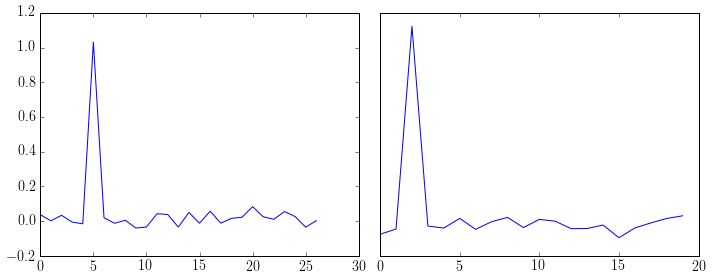

In [33]:
figure(figsize=(10,4))

subplot(121)
plot(x_coef2 * N)

subplot(122)
plot(t_coef2 * N)
yticks([])

plt.tight_layout()

**Figure: Slight/subtle/zero noise improvement with futher iterations.**

## Unbinding Capacity



In [392]:

def resonance_decode(n_steps=20, N=10000, D=(180, 180, 80)):
    
    vecs = []
    input_coefs = []
    x_states = []
    x_hists = []
    bound_vec = np.ones(N)
    
    for iD, Dv in enumerate(D):
        v = 2 * (np.random.randn(Dv, N) < 0) - 1
        vecs.append(v)
        
        # 
        ic_idx = np.random.randint(Dv)
        i_coefs = np.zeros(Dv)
        i_coefs[ic_idx] = 1.0
        input_coefs.append(i_coefs)
        
        bound_vec *= np.dot(i_coefs, v)
        
        x_st = np.random.randn(N)
        x_st = x_st / np.linalg.norm(x_st)
        x_states.append(x_st)
        
        x_hi = np.zeros((n_steps, Dv))
        x_hists.append(x_hi)
        

    for i in range(n_steps):
        th_vec = bound_vec.copy()
        all_converged = np.zeros(len(D))
        for iD, Dv in enumerate(D):
            
            x_hists[iD][i, :] = np.dot(vecs[iD], x_states[iD])
            
            if i > 1:
                all_converged[iD] = np.allclose(x_hists[iD][i,:], x_hists[iD][i-1, :])
            
            xidx = np.argmax(np.abs(x_hists[iD][i, :]))            
            x_states[iD] *= np.sign(x_hists[iD][i, xidx])
            th_vec *= x_states[iD] 
        
        if np.all(all_converged):
            print 'converged:', i,
            break
            
        for iD, Dv in enumerate(D):
            x_upd = th_vec / x_states[iD]
            
            x_upd = np.dot(vecs[iD].T, np.dot(x_upd, vecs[iD].T))
            
            x_states[iD] = x_upd / np.linalg.norm(x_upd)
              
        
    return x_hists, input_coefs, i



converged: 21


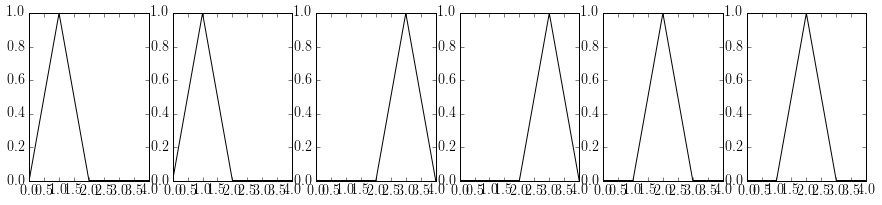

In [393]:
max_steps = 200
N = 2000
D = (5, 5, 5, 5, 5, 5)
#D = (10, 100, 200)
#D = (500, 400)

x_hists, input_coefs, n_steps = resonance_decode(max_steps, N=N, D=D)

figure(figsize=(15,3))


for iD in range(len(x_hists)):
    subplot(1, len(x_hists), iD+1)
    plot(input_coefs[iD], c='k')
    
    

In [394]:
np.allclose(x_hists[0][-1, :], x_hists[0][-2, :])


True

In [395]:
print 20**4, 8*20*1000, 80*20*100
print np.prod(D)

160000 160000 160000
15625


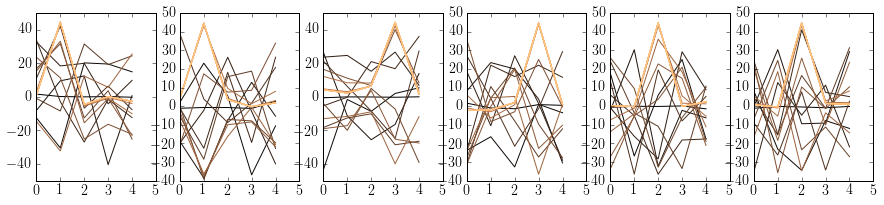

In [396]:
figure(figsize=(15,3))

cols = get_cmap('copper', n_steps)

for iD in range(len(x_hists)):
    subplot(1, len(x_hists), iD+1)
    for istep in range(n_steps):
        plot(x_hists[iD][istep, :], c=cols(istep))
    
    xlim([0, D[iD]])
    

In [311]:
test_N = [400, 700, 1000, 1300, 1600]
#test_depth = [2, 3, 4, 5, 6]
test_factors = [3, 4, 5];
n_runs = 20

max_steps = 500

depth = 6

n_steps_all = np.zeros((n_runs, len(test_factors), 10, len(test_N)))
error_all = np.zeros((n_runs, len(test_factors), 10, len(test_N)))
iscorr_all = np.zeros((n_runs, len(test_factors), 10, len(test_N)))

for nr in range(n_runs):
    for itf, tf in enumerate(test_factors):
        print tf,
        tst = time.time()
        test_D = [(tf**4, tf**2),
                  (tf**3, tf**3),
                  (tf**3, tf**2, tf),
                  (tf**2, tf**2, tf**2),
                  (tf**2, tf**2, tf, tf),                  
                  (tf**5, tf),
                  (tf**4, tf, tf),
                  (tf**3, tf, tf, tf),
                  (tf**2, tf, tf, tf, tf),
                  (tf, tf, tf, tf, tf, tf)]
        
    
        for itD, vvD in enumerate(test_D):
            print vvD,
            for iN, N in enumerate(test_N):
                x_hists, input_coefs, n_steps = resonance_decode(max_steps, N=N, D=vvD)
                
                n_steps_all[nr, itf, itD, iN] = n_steps
                iscorr_all[nr, itf, itD, iN] = True
                
                for idd, vdd in enumerate(vvD):
                    error_all[nr, itf, itD, iN] += (np.sum((x_hists[idd][n_steps, :] - input_coefs[idd])**2)**0.5)
                    if not np.argmax(np.abs(x_hists[idd][n_steps, :])) == np.argmax(input_coefs[idd]):
                        iscorr_all[nr, itf, itD, iN] = False
        
        print 'Elapsed: ', time.time() - tst

3 (81, 9) converged: 32 converged: 20 converged: 16 converged: 17 converged: 17 (27, 27) converged: 24 converged: 17 converged: 17 converged: 15 converged: 15 (27, 9, 3) converged: 20 converged: 19 converged: 15 converged: 13 converged: 13 (9, 9, 9) converged: 21 converged: 19 converged: 12 converged: 14 converged: 15 (9, 9, 3, 3) converged: 21 converged: 15 converged: 14 converged: 14 converged: 13 (243, 3) converged: 42 converged: 24 converged: 24 converged: 22 converged: 23 (81, 3, 3) converged: 27 converged: 24 converged: 16 converged: 17 converged: 15 (27, 3, 3, 3) converged: 20 converged: 14 converged: 16 converged: 15 converged: 14 (9, 3, 3, 3, 3) converged: 24 converged: 15 converged: 18 converged: 14 converged: 13 (3, 3, 3, 3, 3, 3) converged: 26 converged: 16 converged: 12 converged: 11 converged: 18 Elapsed:  1.44217586517
4 (256, 16) converged: 83 converged: 39 converged: 32 converged: 27 converged: 28 (64, 64) converged: 49 converged: 31 converged: 28 converged: 20 converg

In [346]:
test_N = [350, 400, 500, 700, 1000, 1400]
#test_depth = [2, 3, 4, 5, 6]
test_factors = [3, 4, 5, 6, 7, 8, 9];
n_runs = 10

max_steps = 500

depth = 5

n_steps_all = np.zeros((n_runs, len(test_factors), 6, len(test_N)))
error_all = np.zeros((n_runs, len(test_factors), 6, len(test_N)))
iscorr_all = np.zeros((n_runs, len(test_factors), 6, len(test_N)))

for nr in range(n_runs):
    for itf, tf in enumerate(test_factors):
        print tf,
        tst = time.time()
        ## HACKING THIS IN ##
        test_D = [(tf**4, tf),
                  (tf**3, tf**2),
                  (tf**2, tf**2, tf),
                  (tf**3, tf, tf),
                  (tf**2, tf, tf, tf),
                  (tf, tf, tf, tf, tf)]
        
    
        for itD, vvD in enumerate(test_D):
            print vvD,
            for iN, N in enumerate(test_N):
                x_hists, input_coefs, n_steps = resonance_decode(max_steps, N=N, D=vvD)
                
                n_steps_all[nr, itf, itD, iN] = n_steps
                iscorr_all[nr, itf, itD, iN] = True
                
                for idd, vdd in enumerate(vvD):
                    error_all[nr, itf, itD, iN] += (np.sum((x_hists[idd][n_steps, :] - input_coefs[idd])**2)**0.5)
                    if not np.argmax(np.abs(x_hists[idd][n_steps, :])) == np.argmax(input_coefs[idd]):
                        iscorr_all[nr, itf, itD, iN] = False
        
        print 'Elapsed: ', time.time() - tst

 3 (81, 3) converged: 20 converged: 21 converged: 20 converged: 17 converged: 17 converged: 15 (27, 9) converged: 20 converged: 18 converged: 18 converged: 14 converged: 13 converged: 12 (9, 9, 3) converged: 22 converged: 15 converged: 14 converged: 14 converged: 12 converged: 13 (27, 3, 3) converged: 17 converged: 19 converged: 18 converged: 17 converged: 15 converged: 12 (9, 3, 3, 3) converged: 17 converged: 14 converged: 21 converged: 14 converged: 12 converged: 11 (3, 3, 3, 3, 3) converged: 27 converged: 14 converged: 12 converged: 12 converged: 14 converged: 10 Elapsed:  0.605315923691
4 (256, 4) converged: 40 converged: 40 converged: 34 converged: 34 converged: 26 converged: 23 (64, 16) converged: 33 converged: 28 converged: 26 converged: 19 converged: 20 converged: 19 (16, 16, 4) converged: 27 converged: 29 converged: 17 converged: 19 converged: 17 converged: 16 (64, 4, 4) converged: 42 converged: 26 converged: 20 converged: 22 converged: 17 converged: 16 (16, 4, 4, 4) converged

In [347]:
depth_all = np.zeros(len(test_D))

for iD in range(len(test_D)):
    depth_all[iD] = len(test_D[iD])

print depth_all

[ 2.  2.  3.  3.  4.  5.]


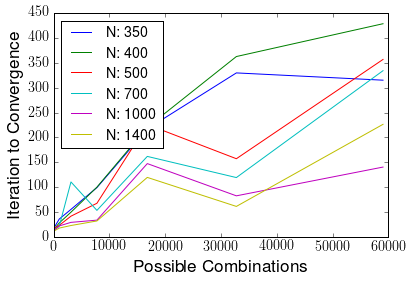

In [356]:
nN_steps = n_steps_all[0, :, :, :].mean(axis=1)

for iN, vN in enumerate(test_N):
    plot(np.array(test_factors)**depth, nN_steps[:, iN], label='N: ' + str(vN))
   
ylabel('Iteration to Convergence')
xlabel('Possible Combinations')
legend(loc='upper left')

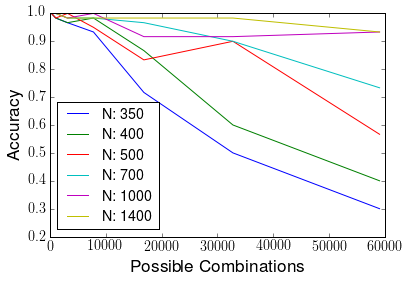

In [357]:
nN_corr = iscorr_all.mean(axis=0).mean(axis=1)

for iN, vN in enumerate(test_N):
    plot(np.array(test_factors)**depth, nN_corr[:, iN], label='N: ' + str(vN))
   
ylabel('Accuracy')
xlabel('Possible Combinations')
legend(loc='lower left')

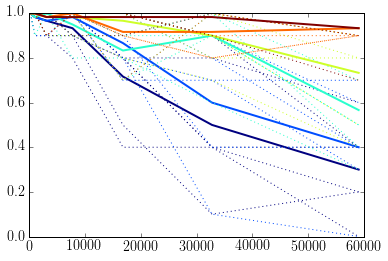

In [350]:
Ncols = get_cmap('jet', len(test_N))
isc_mean = iscorr_all.mean(axis=0)

for iN, Nv in enumerate(test_N):
    for tf in range(iscorr_all.shape[2]):
        plot(np.array(test_factors)**depth, isc_mean[:, tf, iN], ':', c=Ncols(iN))
        
    plot(np.array(test_factors)**depth, isc_mean[:,:,iN].mean(axis=1), lw=2, c=Ncols(iN))

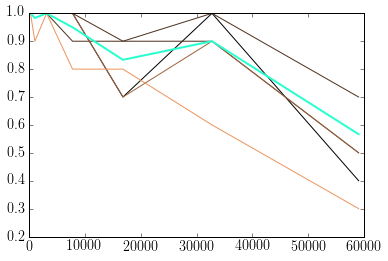

In [360]:
ddepth = [2, 2, 3, 3, 4, 5]
ud = unique(ddepth)
tf_cols = get_cmap('copper', len(ud))
isc_mean = iscorr_all.mean(axis=0)
iN = 2

for tf in range(iscorr_all.shape[2]):
    didx = np.nonzero(ud == ddepth[tf])[0]
    plot(np.array(test_factors)**depth, isc_mean[:, tf, iN], c=cols(didx[0]))

plot(np.array(test_factors)**depth, isc_mean[:,:,iN].mean(axis=1), lw=2, c=Ncols(iN))

In [326]:
ud

array([ 2.,  3.,  4.,  5.,  6.])

In [323]:
cols(didx[0])

(0.5, 0.0, 0.0, 1.0)

In [309]:
iscorr_all

array([[[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 0.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]]],


       [[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
    

In [266]:
for i in range(len(test_D)):
    print np.prod(test_D[i])

1000000
1000000
1000000
1000000
1000000
1000000


## Resonance Attractors for Unbinding Inference

So, it makes a bit of sense that iterating multiple steps can improve the SNR of the inference as the guess gets cleaner. This is because what we mean by "cleaner" is actually akin to superposing fewer potential transforms. This means that the noise is reduced based on the capacity theory.

Here, I am going to utilize a "resonance attractor" to perform the inference. This is going to effectively implement this iterative procedure for performing the unbinding, and it looks much like a hopfield net!

The resonance attractor is very similar to a hopfield net, but is based on forming the recurrent matrix such that all of the hypervector symbols used are the eigenvectors of the matrix with eigenvalues of 1. From my previous experiments with this idea, such a network will attract the high-dimensional hypervector state to a location on the lower-dimensional manifold formed by the eigenvectors -- i.e. anywhere on the space spanned by the set of eigenvectors. This isn't great for, say, pattern completion, but it does act as a "line attractor" (but higher-dimensional), which I thought could have potential. We will use normalization to make sure things don't explode, and having normalization has other nice properties.

The matrix is formed by:

$$
\mathbf{R}_X = X^{-1} \mathbf{I} X
$$

and similarly

$$
\mathbf{R}_T = T^{-1} \mathbf{I} T
$$

We will make this resonance matrix for both the set of objects and the set of transforms. 

(I believe that when using the +1,-1 coding scheme, that this is in fact the same as a hopfield net weight matrix, but there are not heaviside nonlinearities in this network and there is normalization).

We can solve a simultaneous optimization by having each of the basis sets use the resonance attractor to figure out the bound pair. We use the state of the object attractor to set the coefficients for the guess, this guess is bound to the input (i.e. the inverse bind) and the result is fed into the transform attractor. The transform attractor will project the coefficients onto the basis space formed by the hypervector codewords. This projection serves as the guess for the transform that was applied to the objects. The object resonator now has a better guess, and iteratively the guess improves until convergence -- where convergence is actually sustaining a resonance with the eigenvectors.



In [397]:
N = 500

objD = 30
trfD = 40

obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1
#obj_vecs = obj_vecs / N**0.5
#trf_vecs = trf_vecs / N**0.5

# This sets the coefficients of the two bound vectors
b_objc = np.zeros(objD)
b_trfc = np.zeros(trfD)

# We'll turn two vectors on by giving them coefficients of 1
b_objc[10] = 1
#b_objc[20] = 0.7

b_trfc[14] = 1
#b_trfc[18] = 1

bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs)

# By resonance, I mean positive feedback by having the eigenvectors grow and then be renormalized
# having the eigenvalues as 1 is good enough though (any positive value really e.g. it is 0 vs. 1)
eignorm = 1
obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)
trf_resonance = np.dot(np.dot(pinv(trf_vecs), eignorm * np.eye(trfD)), trf_vecs)

# So instead of setting the initial vectors to be the sum of all potential,
# we can just set it randomly
obj_state = np.random.randn(N)
trf_state = np.random.randn(N)
#trf_state = trf_vecs.sum(axis=0)
#let_state = let_vecs.sum(axis=0)

obj_state = obj_state / np.linalg.norm(obj_state)
trf_state = trf_state / np.linalg.norm(trf_state)


n_steps = 10

obj_coef_hist = np.zeros((n_steps, objD))
trf_coef_hist = np.zeros((n_steps, trfD))

thal_vec = np.zeros_like(bound_vec)

for i in range(n_steps):
    thal_vec[:] = bound_vec
    
    obj_coef_hist[i,:] = np.dot(obj_vecs, obj_state) / N**0.5
    trf_coef_hist[i,:] = np.dot(trf_vecs, trf_state) / N**0.5
    
    thal_vec -= trf_state * obj_state *N
    
    obj_state = np.dot(obj_resonance, trf_state * thal_vec + obj_state)
    #obj_state = obj_state / np.linalg.norm(obj_state)

    trf_state = np.dot(trf_resonance, obj_state * thal_vec + trf_state) 
    #trf_state = trf_state / np.linalg.norm(trf_state)

    

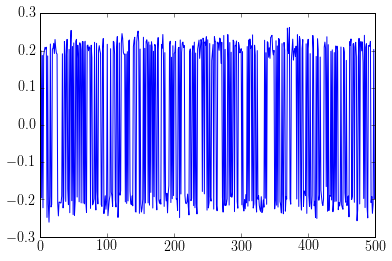

In [398]:
plot(thal_vec)

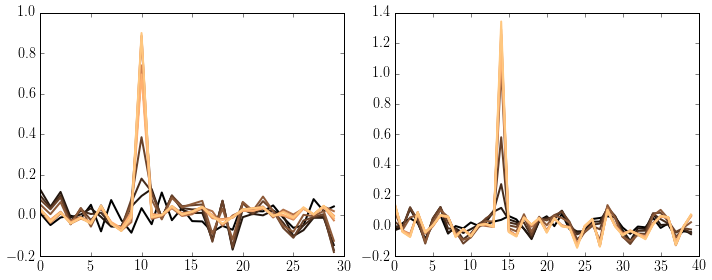

In [399]:
cols = get_cmap('copper', n_steps)

figure(figsize=(10,4))

for i in range(n_steps):
    subplot(121)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    subplot(122)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)

plt.tight_layout()

In [37]:
N = 5000

objD = 120
trfD = 60

obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1
obj_vecs = obj_vecs / N**0.5
trf_vecs = trf_vecs / N**0.5

# This sets the coefficients of the two bound vectors
b_objc = np.zeros(objD)
b_trfc = np.zeros(trfD)

# We'll turn two vectors on by giving them coefficients of 1
b_objc[10] = 1
b_objc[20] = 0.7

b_trfc[14] = 1
b_trfc[18] = 1

bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs) + obj_vecs[-10] * trf_vecs[-14]

# By resonance, I mean positive feedback by having the eigenvectors grow and then be renormalized
# having the eigenvalues as 1 is good enough though (any positive value really e.g. it is 0 vs. 1)
eignorm = 1
obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)
trf_resonance = np.dot(np.dot(pinv(trf_vecs), eignorm * np.eye(trfD)), trf_vecs)

# So instead of setting the initial vectors to be the sum of all potential,
# we can just set it randomly
obj_state = np.random.randn(N)
trf_state = np.random.randn(N)
#trf_state = trf_vecs.sum(axis=0)
#let_state = let_vecs.sum(axis=0)

obj_state = obj_state / np.linalg.norm(obj_state)
trf_state = trf_state / np.linalg.norm(trf_state)

obj_state2 = np.random.randn(N)
trf_state2 = np.random.randn(N)
#trf_state = trf_vecs.sum(axis=0)
#let_state = let_vecs.sum(axis=0)

obj_state2 = obj_state2 / np.linalg.norm(obj_state2)
trf_state2 = trf_state2 / np.linalg.norm(trf_state2)


n_steps = 20

obj_coef_hist = np.zeros((n_steps, objD))
trf_coef_hist = np.zeros((n_steps, trfD))
obj_coef_hist2 = np.zeros((n_steps, objD))
trf_coef_hist2 = np.zeros((n_steps, trfD))

thal_vec = np.zeros_like(bound_vec)

for i in range(n_steps):
    thal_vec[:] = bound_vec
    
    obj_coef_hist[i,:] = np.dot(obj_vecs, obj_state)
    trf_coef_hist[i,:] = np.dot(trf_vecs, trf_state)
    
    obj_coef_hist2[i,:] = np.dot(obj_vecs, obj_state2)
    trf_coef_hist2[i,:] = np.dot(trf_vecs, trf_state2)
    
    thal_vec -= (trf_state * obj_state + trf_state2 * obj_state2)
    
    obj_state = np.dot(obj_resonance, 35*trf_state * thal_vec * N**0.5 + obj_state)
    #obj_state = obj_state / np.linalg.norm(obj_state)

    trf_state = np.dot(trf_resonance, 30*obj_state * thal_vec * N**0.5 + trf_state) 
    #trf_state = trf_state / np.linalg.norm(trf_state)

    obj_state2 = np.dot(obj_resonance, 20*trf_state2 * thal_vec * N**0.5 + obj_state2)
    #obj_state = obj_state / np.linalg.norm(obj_state)

    trf_state2 = np.dot(trf_resonance, 25*obj_state2 * thal_vec * N**0.5 + trf_state2) 
    

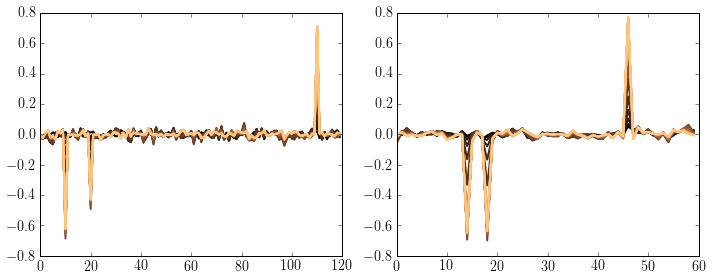

In [38]:
cols = get_cmap('copper', n_steps)

figure(figsize=(10,4))

for i in range(n_steps):
    subplot(121)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    subplot(122)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)

plt.tight_layout()

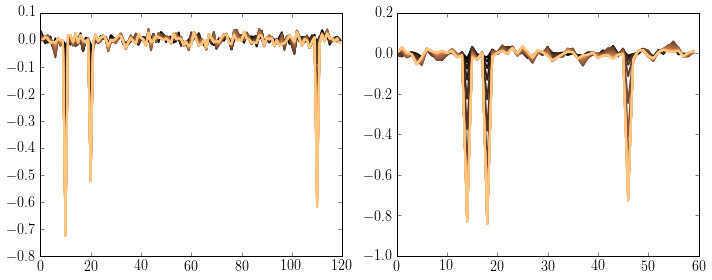

In [39]:
cols = get_cmap('copper', n_steps)

figure(figsize=(10,4))

for i in range(n_steps):
    subplot(121)
    plot(obj_coef_hist2[i,:], c=cols(i), lw=2)
    subplot(122)
    plot(trf_coef_hist2[i,:], c=cols(i), lw=2)

plt.tight_layout()

**Figure: Resonance Attractor Convergence.** The resonance attractor is fed an input which is based on two bound items. The attractor begins with a random guess (not necessary to make the guess coefficients all +1 as before), and then iteratively converges to a potential solution. Black: first iteration, Copper: last iteration.

So that is pretty nice! We can recover the object and the transformation using this resonance attractor. One thing to note is that I am always renormalizing, so the vector codes have constant length. This means that the coefficients are only encoded relative to each other in magnitude, and their absolute values are lost.

How far can we push it? Can we unbind more items?

Lets try unbinding three memory items, and not only that, we are going to make each one a superposition of its basis vectors! Superposition can be used to encode complex things like images. This means we are receiving a bound vector ($\mathbf{B}$) that is made up of three vectors, where each of the three is a weighted superposition of a known set of basis vectors, i.e.:

$$
\mathbf{B} = \left( \sum_\ell \alpha_\ell X_\ell \right) \times \left( \sum_m \alpha_m T_m \right) \times \left( \sum_n \alpha_n U_n \right)
$$

And the goal is to approximately recover all of the coefficients. Again, we are going to use the same resonance network strategy, but with three different resonance attractors. Each one will try and resonate with the set of memory vectors and the network will hopefully converge to recover the coefficients ($\alpha_{\ell, m, n}$).

In [40]:
N = 10000

# Lets have a lot more basis vectors
objD = 120
trfD = 60
tr3D = 90

obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1
tr3_vecs = 2 * (np.random.randn(tr3D, N) < 0) - 1

obj_vecs = obj_vecs / N**0.5
trf_vecs = trf_vecs / N**0.5
tr3_vecs = tr3_vecs / N**0.5

# Now lets set several positive coefficients.
b_objc = np.zeros(objD)
b_trfc = np.zeros(trfD)
b_tr3c = np.zeros(tr3D)

b_objc[10] = 1
b_objc[20] = 0.7
b_objc[60] = 1
b_objc[100] = 0.4

#b_trfc[4] = 1
b_trfc[18] = 0.9
b_trfc[48] = 1
b_trfc[12] = 1

b_tr3c[12] = 0.5
b_tr3c[44] = 1

bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs) * np.dot(b_tr3c, tr3_vecs)

eignorm = 1
obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)
trf_resonance = np.dot(np.dot(pinv(trf_vecs), eignorm * np.eye(trfD)), trf_vecs)
tr3_resonance = np.dot(np.dot(pinv(tr3_vecs), eignorm * np.eye(tr3D)), tr3_vecs)

obj_state = np.random.randn(N)
trf_state = np.random.randn(N)
tr3_state = np.random.randn(N)
#trf_state = trf_vecs.sum(axis=0)
#let_state = let_vecs.sum(axis=0)
#tr3_state = tr3_vecs.sum(axis=0)

obj_state = obj_state / np.linalg.norm(obj_state)
trf_state = trf_state / np.linalg.norm(trf_state)
tr3_state = tr3_state / np.linalg.norm(tr3_state)

n_steps = 25

obj_coef_hist = np.zeros((n_steps, objD))
trf_coef_hist = np.zeros((n_steps, trfD))
tr3_coef_hist = np.zeros((n_steps, tr3D))

for i in range(n_steps):
    
    obj_coef_hist[i,:] = np.dot(obj_vecs, obj_state)
    trf_coef_hist[i,:] = np.dot(trf_vecs, trf_state)
    tr3_coef_hist[i,:] = np.dot(tr3_vecs, tr3_state)
    
    thal_vec = bound_vec * trf_state * obj_state * tr3_state
    thal_vec = thal_vec / norm(thal_vec)
    
    obj_state = np.dot(obj_resonance, thal_vec / obj_state)
    obj_state = obj_state / np.linalg.norm(obj_state)

    trf_state = np.dot(trf_resonance, thal_vec / trf_state) 
    trf_state = trf_state / np.linalg.norm(trf_state)

    tr3_state = np.dot(tr3_resonance, thal_vec / tr3_state) 
    tr3_state = tr3_state / np.linalg.norm(tr3_state)

    

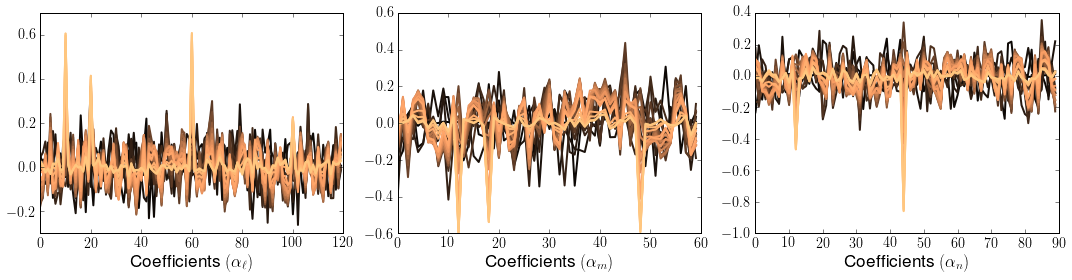

In [41]:

cols = get_cmap('copper', n_steps)

figure(figsize=(15,4))

for i in range(n_steps):
    subplot(131)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_\ell) $')
    subplot(132)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_m) $')
    subplot(133)
    plot(tr3_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_n) $')

plt.tight_layout()

**Figure: Multiple weighted coefficients can be inferred in the resonance attractor.** Black: first iteration, Copper: last iteration.

So we can see that the true coefficients can be quite nicely found! So now we have the ability to decode any set of bound vectors. This is going to be useful for our map-seeking circuit ideas.

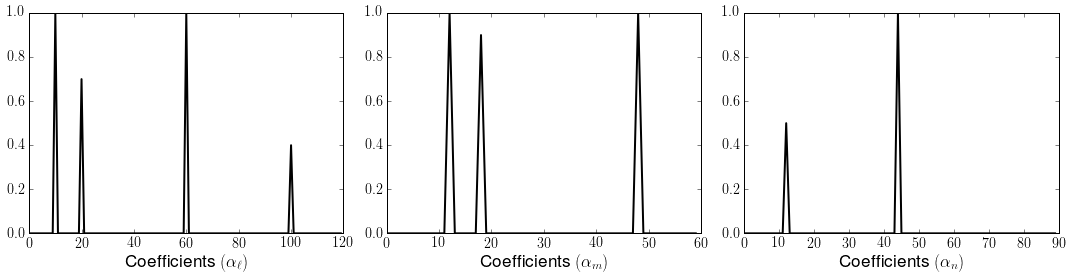

In [42]:
figure(figsize=(15,4))

subplot(131)
plot(b_objc, c='k', lw=2)
xlabel(r'Coefficients $ (\alpha_\ell) $')
subplot(132)
plot(b_trfc, c='k', lw=2)
xlabel(r'Coefficients $ (\alpha_m) $')
subplot(133)
plot(b_tr3c, c='k', lw=2)
xlabel(r'Coefficients $ (\alpha_n) $')

plt.tight_layout()

**Figure: Original coefficients.**

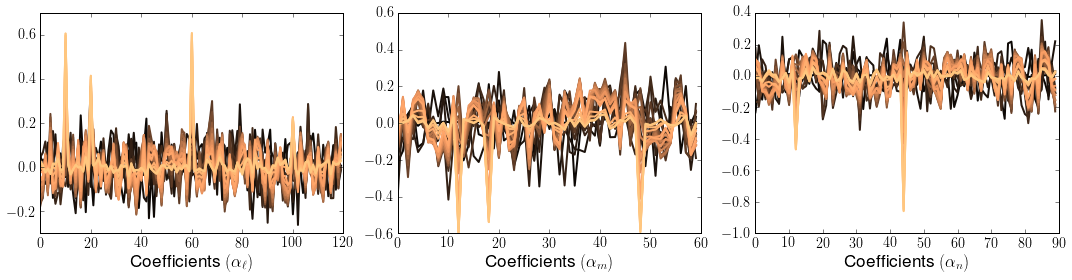

In [43]:

cols = get_cmap('copper', n_steps)

figure(figsize=(15,4))

for i in range(n_steps):
    subplot(131)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_\ell) $')
    subplot(132)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_m) $')
    subplot(133)
    plot(tr3_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_n) $')

plt.tight_layout()

**Figure: Sometimes the sign of the coefficients can flip.** This makes a ton of sense because you can multiply by -1 in two places and get the same answer.



In [44]:

def resonance_decode(n_steps=20, N=10000, D=(180, 180, 80)):
    
    objD, trfD, tr3D = D
    
    obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
    trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1
    tr3_vecs = 2 * (np.random.randn(tr3D, N) < 0) - 1

    obj_vecs = obj_vecs / N**0.5
    trf_vecs = trf_vecs / N**0.5
    tr3_vecs = tr3_vecs / N**0.5

    # Now lets set several positive coeficients.
    b_objc = np.zeros(objD)
    b_trfc = np.zeros(trfD)
    b_tr3c = np.zeros(tr3D)

    b_objc[10] = 1
    b_objc[20] = 0.7
    b_objc[60] = 1
    
    b_objc = b_objc / np.linalg.norm(b_objc)

    b_trfc[4] = 1
    b_trfc[-11] = 0.9
    b_trfc[48] = 1
    b_trfc[12] = 1
    b_trfc[20] = 0.3
    
    b_trfc = b_trfc / np.linalg.norm(b_trfc)

    b_tr3c[12] = 0.5
    b_tr3c[44] = 1
    
    b_tr3c = b_tr3c / np.linalg.norm(b_tr3c)

    bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs) * np.dot(b_tr3c, tr3_vecs)

    eignorm = 1
    obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)
    trf_resonance = np.dot(np.dot(pinv(trf_vecs), eignorm * np.eye(trfD)), trf_vecs)
    tr3_resonance = np.dot(np.dot(pinv(tr3_vecs), eignorm * np.eye(tr3D)), tr3_vecs)

    obj_state = np.random.randn(N)
    trf_state = np.random.randn(N)
    tr3_state = np.random.randn(N)
    #trf_state = trf_vecs.sum(axis=0)
    #let_state = let_vecs.sum(axis=0)
    #tr3_state = tr3_vecs.sum(axis=0)

    obj_state = obj_state / np.linalg.norm(obj_state)
    trf_state = trf_state / np.linalg.norm(trf_state)
    tr3_state = tr3_state / np.linalg.norm(tr3_state)

    obj_coef_hist = np.zeros((n_steps, objD))
    trf_coef_hist = np.zeros((n_steps, trfD))
    tr3_coef_hist = np.zeros((n_steps, tr3D))
    error_hist = np.zeros((n_steps,3))
    
    for i in range(n_steps):

        obj_coef_hist[i,:] = np.dot(obj_vecs, obj_state)
        trf_coef_hist[i,:] = np.dot(trf_vecs, trf_state)
        tr3_coef_hist[i,:] = np.dot(tr3_vecs, tr3_state)
        
        error_hist[i,0] = np.min((np.sum((b_objc - obj_coef_hist[i,:]) ** 2) ** 0.5, 
                                  np.sum((b_objc + obj_coef_hist[i,:]) ** 2) ** 0.5))
        error_hist[i,1] = np.min((np.sum((b_trfc - trf_coef_hist[i,:]) ** 2) ** 0.5,
                                  np.sum((b_trfc + trf_coef_hist[i,:]) ** 2) ** 0.5))
        
        error_hist[i,2] = np.min((np.sum((b_tr3c - tr3_coef_hist[i,:]) ** 2) ** 0.5,
                                  np.sum((b_tr3c + tr3_coef_hist[i,:]) ** 2) ** 0.5))

        thal_vec = bound_vec * trf_state * obj_state * tr3_state
        thal_vec = thal_vec / np.linalg.norm(thal_vec) + 0.00*np.random.randn(N)

        obj_state = np.dot(obj_resonance, thal_vec / obj_state)
        obj_state = obj_state / np.linalg.norm(obj_state)

        trf_state = np.dot(trf_resonance, thal_vec / trf_state) 
        trf_state = trf_state / np.linalg.norm(trf_state)

        tr3_state = np.dot(tr3_resonance, thal_vec / tr3_state) 
        tr3_state = tr3_state / np.linalg.norm(tr3_state)


    return (obj_coef_hist, trf_coef_hist, tr3_coef_hist), error_hist

In [45]:
n_runs = 10
errors = np.zeros((n_steps, 3, n_runs))

for nr in range(n_runs):
    coeffs, error = resonance_decode(n_steps=n_steps)
    
    errors[:,:,nr] = error

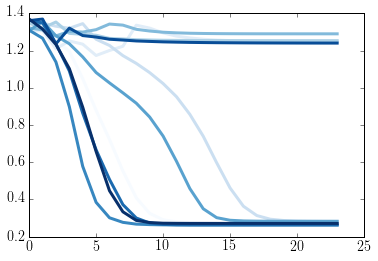

In [49]:
cols = get_cmap('Blues', n_runs)

for nr in range(n_runs):
    #plot(errors[1:,:,nr], c=cols(nr))
    
    plot(errors[1:,:,nr].mean(axis=1), c=cols(nr), lw=3)


## Adding the identity vector

In some sense there is a slight problem with how it works, and this is because of 0. For instance, if I have this 3-way binding inference system, then I have guaranteed that at least 1 item from each memory is bound in the input. However, what happens if there are 0 items? The problem is that we can't just add 0, because that would 0 out everything!

Well, maybe the answer is that each memory area has the binding identity as part of its basis set. This way, the area can effectively be "off", because the identity leaves the bound input unchanged.



In [29]:
N = 10000

# Lets have a lot more basis vectors
objD = 120
trfD = 60
tr3D = 90

obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1
tr3_vecs = 2 * (np.random.randn(tr3D, N) < 0) - 1

# ok replace the extra one at the end with the identity vector
obj_vecs[-1,:] = 1
trf_vecs[-1,:] = 1
tr3_vecs[-1,:] = 1

obj_vecs = obj_vecs / N**0.5
trf_vecs = trf_vecs / N**0.5
tr3_vecs = tr3_vecs / N**0.5

# Now lets set several positive coefficients.
b_objc = np.zeros(objD)
b_trfc = np.zeros(trfD)
b_tr3c = np.zeros(tr3D)

b_objc[10] = 1
b_objc[20] = 0.7
b_objc[60] = 1
b_objc[100] = 0.4

#b_trfc[4] = 1
b_trfc[18] = 0.9
b_trfc[48] = 1
b_trfc[12] = 1

b_tr3c[12] = 0.5
b_tr3c[44] = 1

# This time only bind two of them
#bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs) * np.dot(b_tr3c, tr3_vecs)
#bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_tr3c, tr3_vecs)
bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs)

eignorm = 1
obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)
trf_resonance = np.dot(np.dot(pinv(trf_vecs), eignorm * np.eye(trfD)), trf_vecs)
tr3_resonance = np.dot(np.dot(pinv(tr3_vecs), eignorm * np.eye(tr3D)), tr3_vecs)

obj_state = np.random.randn(N)
trf_state = np.random.randn(N)
tr3_state = np.random.randn(N)
#trf_state = trf_vecs.sum(axis=0)
#let_state = let_vecs.sum(axis=0)
#tr3_state = tr3_vecs.sum(axis=0)

obj_state = obj_state / np.linalg.norm(obj_state)
trf_state = trf_state / np.linalg.norm(trf_state)
tr3_state = tr3_state / np.linalg.norm(tr3_state)

n_steps = 25

obj_coef_hist = np.zeros((n_steps, objD))
trf_coef_hist = np.zeros((n_steps, trfD))
tr3_coef_hist = np.zeros((n_steps, tr3D))

for i in range(n_steps):
    
    obj_coef_hist[i,:] = np.dot(obj_vecs, obj_state)
    trf_coef_hist[i,:] = np.dot(trf_vecs, trf_state)
    tr3_coef_hist[i,:] = np.dot(tr3_vecs, tr3_state)
    
    thal_vec = bound_vec * trf_state * obj_state * tr3_state
    thal_vec = thal_vec / norm(thal_vec)
    
    obj_state = np.dot(obj_resonance, thal_vec / obj_state)
    obj_state = obj_state / np.linalg.norm(obj_state)

    trf_state = np.dot(trf_resonance, thal_vec / trf_state) 
    trf_state = trf_state / np.linalg.norm(trf_state)

    tr3_state = np.dot(tr3_resonance, thal_vec / tr3_state) 
    tr3_state = tr3_state / np.linalg.norm(tr3_state)

    

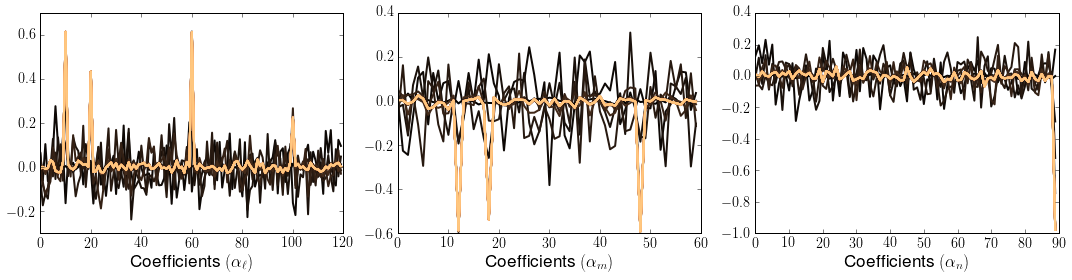

In [30]:

cols = get_cmap('copper', n_steps)

figure(figsize=(15,4))

for i in range(n_steps):
    subplot(131)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_\ell) $')
    subplot(132)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_m) $')
    subplot(133)
    plot(tr3_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_n) $')

plt.tight_layout()

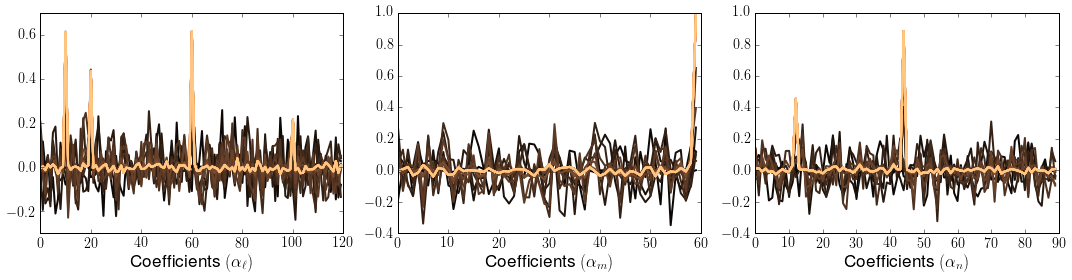

In [26]:

cols = get_cmap('copper', n_steps)

figure(figsize=(15,4))

for i in range(n_steps):
    subplot(131)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_\ell) $')
    subplot(132)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_m) $')
    subplot(133)
    plot(tr3_coef_hist[i,:], c=cols(i), lw=2)
    xlabel(r'Coefficients $ (\alpha_n) $')

plt.tight_layout()

In [15]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1
    

In [8]:
range(1,3)

[1, 2]

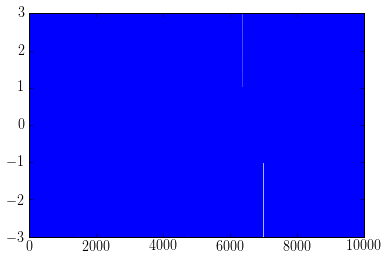

In [17]:


alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


v1 = ngram_encode_cl('the', letter_vecs, alph)
v2 = ngram_encode_cl('abc', letter_vecs, alph)

v3 = v1+v2

print np.dot(v1, v3.T)

10064


In [122]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


ngram_str = 'the'

bound_vec = ngram_encode(ngram_str, letter_vecs, alph)


l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))

l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)


l0_state = letter_vecs[alph.find('#'), :]
l4_state = letter_vecs[alph.find('.'), :]


n_steps = 10

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))

In [123]:
l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2))

l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
        np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
          bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2))

l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
       np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2))

t
h
e


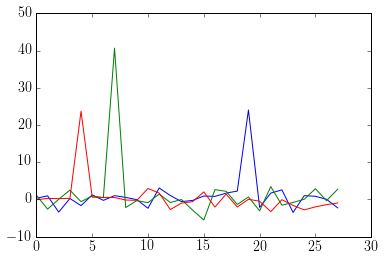

In [124]:
plot(np.dot(l1d, letter_vecs.T))
plot(np.dot(l2d, letter_vecs.T))
plot(np.dot(l3d, letter_vecs.T))

print alph[np.argmax(np.dot(l1d, letter_vecs.T))]
print alph[np.argmax(np.dot(l2d, letter_vecs.T))]
print alph[np.argmax(np.dot(l3d, letter_vecs.T))]

In [121]:
l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T))

l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)

In [125]:
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    
    
    l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2))

    l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
              bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2))

    l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2))

    l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T))
    l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T))
    l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T))

    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)


the


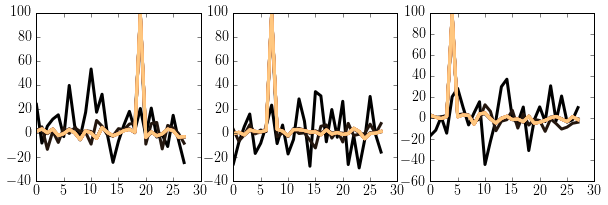

In [128]:
figure(figsize=(10,3))
cols = get_cmap('copper', n_steps)
for i in range(n_steps):
    subplot(131)
    plot(l1_coef_hist[i,:], lw=3, c=cols(i))
    subplot(132)
    plot(l2_coef_hist[i,:], lw=3, c=cols(i))
    subplot(133)
    plot(l3_coef_hist[i,:], lw=3, c=cols(i))
    
    
l1 = alph[np.argmax(l1_coef_hist[-1,:])]
l2 = alph[np.argmax(l2_coef_hist[-1,:])]
l3 = alph[np.argmax(l3_coef_hist[-1,:])]

print l1+l2+l3